In [34]:
import numpy as np
import math
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

# from sam.models import  planted_initialization , interpolation_initialization , create_induction_head
from sam.dataset import get_dataloader

from configurations import load_data, make_params_dict, create_fig, set_font_sizes, apply_general_styles , make_data_paths

apply_general_styles()


# Scalings

In [173]:

class InductionHeadAttention(nn.Module):
    def __init__(
            self,
            vocab_size: int,
            seq_len: int,
            dropout: float = 0.0,
            ) -> None:
        super().__init__()

        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.d_model = vocab_size + seq_len
        self.d_eff = self.seq_len
        self.mask1 = torch.tril(torch.ones((seq_len,seq_len)),diagonal=0) == 0

        # Embeddings
        self.embedding = nn.Embedding(vocab_size, vocab_size)
        self.positions = nn.Embedding(seq_len,seq_len)

        # First layer weights
        self.WQ1 = nn.Linear(self.d_model, self.d_eff, bias=False)
        self.WK1 = nn.Linear(self.d_model, self.d_eff, bias=False)
        self.WV1 = nn.Linear(self.d_model, self.d_model, bias=False)

        # Second layer weights
        self.WQ2 = nn.Linear(self.d_model, self.vocab_size, bias=False)
        self.WK2 = nn.Linear(self.d_model, self.vocab_size, bias=False)
        self.WV2 = nn.Linear(self.d_model, self.vocab_size, bias=False)

        # Dropout
        self.dropout=nn.Dropout(dropout)

        # Scalar Parameters
        self.beta_1 = nn.Parameter(torch.tensor(1.0))
        self.beta_2 = nn.Parameter(torch.tensor(1.0))
        self.beta_out = nn.Parameter(torch.tensor(1.0))

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """ input: (batch_size, seq_len) list of token ids """
        output = {}
        # Input embedding + positional encoding
        E = self.embedding(input) #*math.sqrt(self.d_model) # (batch_size, seq_len, vocab_size)
        P = self.positions(torch.arange(self.seq_len, device=input.device)) #  # (seq_len, seq_len)
        P = P.unsqueeze(0).expand(input.size(0), -1, -1)  # (batch_size, seq_len, seq_len)
        X = torch.cat([E, P], dim=-1)  # (batch_size, seq_len, d_model)
        output['X'] = X.detach().cpu().numpy()[0]
        # FIRST LAYER
        # Compute queries and keys
        Q1 = self.WQ1(X)  # (batch_size, seq_len, d_eff)
        K1 = self.WK1(X)  # (batch_size, seq_len, d_eff)
        V1 = self.WV1(X)  # (batch_size, seq_len, d_model)
        output['Q1'] = Q1.detach().cpu().numpy()[0]
        output['K1'] = K1.detach().cpu().numpy()[0]
        output['V1'] = V1.detach().cpu().numpy()[0]

        # Compute attention scores and attention weights with masking
        S1 = self.beta_1*torch.matmul(Q1, K1.transpose(-2, -1)) * (self.d_model/self.seq_len)**2 #/ math.sqrt(self.d_eff) # (batch_size, seq_len, seq_len)
        output['S1'] = S1.detach().cpu().numpy()[0]
        S1 = S1.masked_fill(self.mask1.unsqueeze(0).to(S1.device), float('-inf'))
        A1 = S1.softmax(dim=-1)  # (batch_size, seq_len, seq_len)
        output['A1'] = A1.detach().cpu().numpy()[0]
        A1 = self.dropout(A1)
        Y1 = torch.matmul(A1, V1)  # (batch_size, seq_len, d_model)
        output['Y1'] = Y1.detach().cpu().numpy()[0]
        Z1 = X + Y1  # (batch_size, seq_len, d_model)
        output['Z1'] = Z1.detach().cpu().numpy()[0]
        # SECOND LAYER
        # Compute queries and keys
        q2 = self.WQ2(Z1[:,-1]).unsqueeze(1)  # (batch_size, 1 , vocab_size)
        K2 = self.WK2(Z1)  # (batch_size, seq_len, vocab_size)
        V2 = self.WV2(Z1)  # (batch_size, seq_len, vocab_size)
        output['q2'] = q2.detach().cpu().numpy()[0]
        output['K2'] = K2.detach().cpu().numpy()[0]
        output['V2'] = V2.detach().cpu().numpy()[0]

        # Compute attention scores and attention weights with masking
        S2 = self.beta_2*torch.matmul(q2, K2.transpose(-2, -1)) * (self.d_model/self.vocab_size)**2 #/math.sqrt(self.vocab_size) # (batch_size, 1, seq_len)
        output['S2'] = S2.detach().cpu().numpy()[0]
        # S2 = S2.masked_fill(self.mask2.unsqueeze(0).to(S2.device), float('-inf'))
        # S2[:,:,-1] = float('-inf')  # Prevent attending to the last token
        # Mask out all positions whose token is the same as the last token
        last_tokens = input[:, -1].unsqueeze(1)  # (batch_size, 1)
        token_mask = (input != last_tokens).unsqueeze(1)  # (batch_size, 1, seq_len)
        # S2 = S2.masked_fill(~token_mask.to(S2.device), float('-inf'))
        A2 = S2.softmax(dim=-1)  # (batch_size, 1, seq_len)
        output['A2'] = A2.detach().cpu().numpy()[0]
        A2 = self.dropout(A2)
        Y2 = torch.matmul(A2, V2)  # (batch_size, 1, vocab_size)

        # Compute logit outputs as projection onto embeddings
        logits = self.beta_out*torch.matmul(Y2, self.embedding.weight.t())* (self.d_model/self.vocab_size)**1.5 #math.sqrt(self.d_model/self.vocab_size) # (batch_size, 1, vocab_size)
        output['logits'] = logits.detach().cpu().numpy()[0]
        # Return logits at last position only
        # return  logits[:,0,:]  # (batch_size, vocab_size)
        return output


def planted_initialization(model: InductionHeadAttention, alpha:float,betas:tuple) -> None:

    V = model.vocab_size
    L = model.seq_len
    d_model = model.d_model
    beta_1, beta_2, beta_out = betas

    sigma = 1.0 / math.sqrt(d_model)
    a = alpha**(0.25)

    # Constants for scaling
    Ce = math.sqrt(V/d_model)
    Cp = math.sqrt(L/d_model)
    C1 = math.sqrt(L/d_model)
    Cv1 = math.sqrt(V/d_model)

    C2 = math.sqrt(V/d_model)


    # Matrices
    IdV = torch.eye(V)
    IdL = torch.eye(L)
    Zeros_LV = torch.zeros((L, V))
    shift = torch.zeros((L, L))
    shift[1:,:-1] = torch.eye(L-1)

    # V1 = torch.zeros((d_model, d_model))
    aux_V1 = torch.eye(V)
    aux_V1 = a*Cv1*aux_V1 + (1-a)*sigma*torch.randn_like(aux_V1)
    M = torch.zeros((d_model, d_model))
    M[:V,:V] = aux_V1*math.sqrt(d_model/V)

    K = torch.cat((torch.eye(V), torch.zeros((V,L))), dim=1)

    with torch.no_grad():
        # Embeddings as one-hot encodding
        model.embedding.weight.copy_(Ce*torch.eye(V))
        # Positional encoding as one-hot encodding
        model.positions.weight.copy_(Cp*torch.eye(L))

        # First layer
        model.WQ1.weight.copy_( torch.cat([Zeros_LV, a*C1*IdL + (1-a)*sigma*torch.randn_like(IdL)] , dim=1)) 
        model.WK1.weight.copy_( torch.cat([Zeros_LV, a*C1*shift + (1-a)*sigma*torch.randn_like(IdL)], dim=1))
        model.WV1.weight.copy_(M)

        # Second layer
        model.WQ2.weight.copy_(torch.cat([a*C2*IdV + (1-a)*sigma*torch.randn_like(IdV), Zeros_LV.T], dim=1))
        model.WK2.weight.copy_(torch.cat([a*C2*IdV + (1-a)*sigma*torch.randn_like(IdV), Zeros_LV.T], dim=1))
        model.WV2.weight.copy_(torch.cat([a*C2*IdV + (1-a)*sigma*torch.randn_like(IdV), Zeros_LV.T], dim=1))

        # Scalar parameters
        model.beta_1.copy_(torch.tensor(beta_1))
        model.beta_2.copy_(torch.tensor(beta_2))
        model.beta_out.copy_(torch.tensor(beta_out))
    


def interpolation_initialization(model: InductionHeadAttention, alpha: float = 0.0) -> None:
    """Initialize the Induction Head Attention model with interpolation initialization.
    
    The interpolation is between the model's current parameters and random 
    gaussian parameters with std = 1/sqrt(d_model). The interpolation is controlled by the alpha parameter, where:
    - alpha = 0 corresponds to the original parameters (no change)
    - alpha = 1 corresponds to completely random parameters (full change)
    Args:        
        model (InductionHeadAttention): The model to initialize.
        alpha (float): Interpolation parameter between 0 and 1.
    """
    # Create a temporary model with default initialization


    std = 1.0 / math.sqrt(model.d_model)
    with torch.no_grad():
        for param in model.parameters():
            # Skip scalar parameters (beta_1, beta_2, beta_out)
            if param.shape == torch.Size([]):
                continue
            param.copy_( math.sqrt(1 - alpha**2) * param + alpha * std * torch.randn_like(param) )




In [183]:
config = {
    'vocab_size': 5000,
    'seq_len': 10,
    'dropout': 0.0,
    'alpha': 0.5,
    'batch_size': 1,
    'dataset_size': 10,
    'train_fraction': 0.8,
    'beta_1': 5.0,
    'beta_2': 1.0,
    'beta_out': 1.0
}

model = InductionHeadAttention(config['vocab_size'], config['seq_len'], config['dropout'])
planted_initialization(model, alpha=config['alpha'],betas=(config['beta_1'], config['beta_2'], config['beta_out']))
# interpolation_initialization(model, config['alpha'])

# Get dataloaders
train_loader , val_loader = get_dataloader(config)

for batch in train_loader:
    inputs = batch['input']
    target = batch['target']
    break  # Just process one batch for demonstration

print("Input:", inputs)
print("Target:", target)
print("position where target appears: ", (inputs == target).nonzero(as_tuple=True))

model.eval()
with torch.no_grad():
    output = model(inputs)

for key, value in output.items():
    output[key] = value  # Remove batch dimension for easier visualization
    print(f"{key}: {output[key].shape}")


Input: tensor([[  27, 4058, 4950, 4736, 3352, 2998, 4802,  298, 3142, 3352]])
Target: tensor([2998])
position where target appears:  (tensor([0]), tensor([5]))
X: (10, 5010)
Q1: (10, 10)
K1: (10, 10)
V1: (10, 5010)
S1: (10, 10)
A1: (10, 10)
Y1: (10, 5010)
Z1: (10, 5010)
q2: (1, 5000)
K2: (10, 5000)
V2: (10, 5000)
S2: (1, 10)
A2: (1, 10)
logits: (1, 5000)


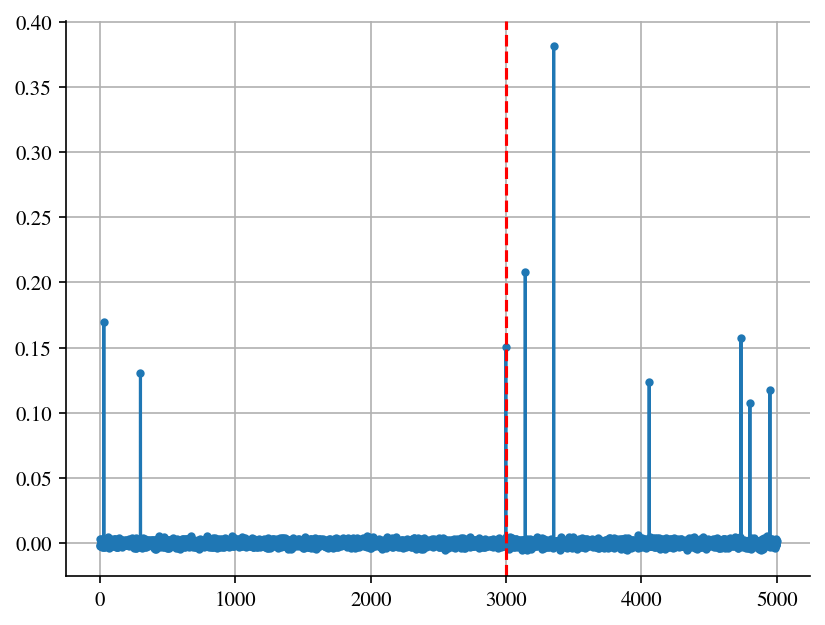

In [185]:
d = model.d_model
L = model.seq_len
key = 'logits'
if key in ['A2','logits','S2']:
    if key == "loglits":
        plt.plot(torch.softmax(torch.tensor(output[key]), dim=-1)[0],marker='.')
    else:
        plt.plot(output[key][0],marker='.')
    plt.grid()
else:
    plt.imshow(output[key],cmap='viridis')
    print(f'std = ',output[key].std())
    print(f'max = ',output[key].max())
    plt.colorbar()

plt.axvline(2998,c='r',ls='--')

# Planted transformer?

In [1]:
# Parameters
vocab_size = 128 # Vocabulary size
seq_len = 64  # Sequence length
# batch_size = 16 # Batch size
# dataset_size = 10000 # Dataset size
# train_fraction = 0.8 # Fraction of data used for training
alpha = 0.5  # Interpolation parameter for initialization (0: planted, 1: random)

lr = 0.0001 # Learning rate



fix_names = ['vocab_size','seq_len']
var_names = ['lr','alpha']

params = make_params_dict(fix_names, var_names)
summary = load_data('summary',experiment_name='induction_head', params=params)

for key in summary:
    print(f'{key} : {summary[key].shape}')


file_path , _, _ = make_data_paths('model_fin', experiment_name= 'induction_head', params=params,ext='pt',base_dir='../data')     
state_model = torch.load(file_path)

for key in state_model.keys():
    print(key, state_model[key].shape if isinstance(state_model[key], torch.Tensor) else type(state_model[key]))
# print(state_model.keys())

NameError: name 'make_params_dict' is not defined

In [323]:
print(state_model['beta_out'])

tensor(3.1437, device='cuda:0')


(64, 64)


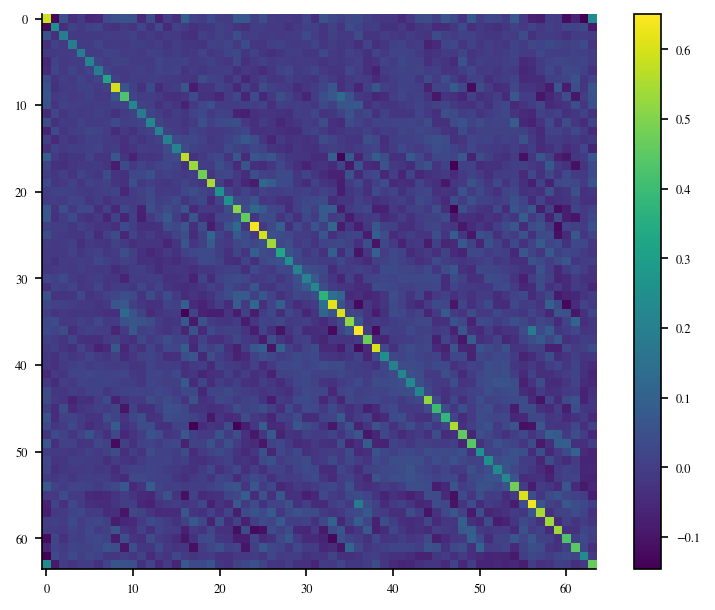

In [317]:
W = state_model['positions.weight'].cpu().numpy()#[:,vocab_size-1:]
print(W.shape)
plt.imshow(W@W.T, cmap='viridis')
plt.colorbar()

(0.0, 1.0)

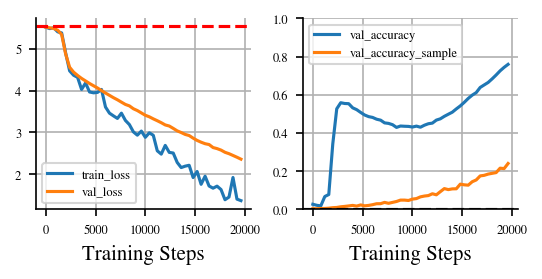

In [318]:
# Settings

set_font_sizes(conf='tight')

# Figure and plot
fig , axes = create_fig(ncols=2,h=0.5)

for ax , vars in zip(axes, [['train_loss','val_loss'], ['val_accuracy','val_accuracy_sample']]):
    for key in vars: 
        ax.plot('step', key, data=summary, label=key )
    ax.legend()
    ax.grid(True)
    ax.set_xlabel('Training Steps')
    
axes[0].axhline(y=math.log(vocab_size), color='r', linestyle='--')
axes[1].axhline(y=1/vocab_size, color='k', linestyle='--')

axes[1].set_ylim(bottom=0,top=1)

(0.0, 1.0)

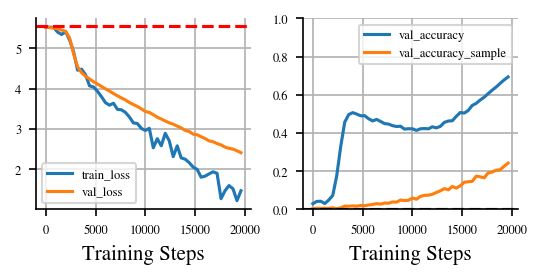

# Runs

In [89]:
d_model = 32
d_eff = 16
vocab_size = 20
seq_len = 16
batch_size = 64
dataset_size = 10000
train_fraction = 0.8
fr_emb = True

sigma = 0.2
lr = 0.0001
n_heads = 1
n_layers = 2
dropout = 0.1
sparsity = 0.0

fix_names = ['d_model','d_eff','vocab_size','seq_len','batch_size','dataset_size','train_fraction','fr_emb']
var_names = ['sigma','lr','n_heads','n_layers','dropout','sparsity']

params = make_params_dict(fix_names, var_names)
summary = load_data('summary',experiment_name='copy_task', params=params)

for key in summary:
    print(f'{key} : {summary[key].shape}')
    

File summary_dropout0.1_lr0.0001_n_heads1_n_layers2_sigma0.2_sparsity0.pkl loaded with pickle.load from /u/c/cerazova/SAM/data/copy_task/batch_size64_d_eff16_d_model32_dataset_size10000_fr_embTrue_seq_len16_train_fraction0.8_vocab_size20
step : (50,)
train_loss : (50,)
val_loss : (50,)
train_accuracy : (0,)
val_accuracy : (50,)


(0.0, 0.119825)

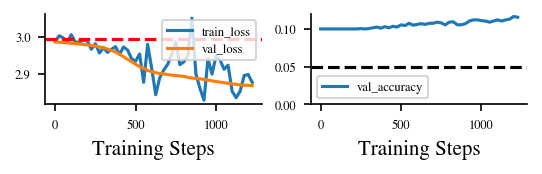

In [90]:
# Settings

set_font_sizes(conf='tight')

# Figure and plot
fig , axes = create_fig(ncols=2,h=0.3)

for ax , vars in zip(axes, [['train_loss','val_loss'], ['val_accuracy']]):
    for key in vars: 
        ax.plot('step', key, data=summary, label=key)
    ax.legend()
    ax.set_xlabel('Training Steps')
    
axes[0].axhline(y=math.log(vocab_size), color='r', linestyle='--')
axes[1].axhline(y=1/vocab_size, color='k', linestyle='--')
axes[1].set_ylim(bottom=0)

In [74]:
print(np.max(summary['val_accuracy']))
print(summary['step'][-1])

0.2305
61250


# Oth

In [13]:
config = {
    'd_model': 128,
    'd_eff': 32,
    'vocab_size': 100,
    'seq_len': 64,
    'n_heads': 3,
    'n_layers': 2,
    'dropout': 0.0,
    'sigma': 0.2,
    'batch_size': 16,
    'dataset_size': 1000,
    'train_fraction': 0.8,
    'lr': 1e-3,
}
model , device = create_transformer(config)
train_dataloader, val_dataloader = get_dataloader(config)


In [14]:
CE_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=config['lr'],eps=1e-9)

print(f'{math.log(config["vocab_size"]):.4f} bits per token')

for batch in train_dataloader:
    input = batch['input'].to(device)
    target = batch['target'].to(device)
    mask = batch['mask'].to(device)

    logits = model(input, mask)
    loss = CE_loss(logits.view(-1, config['vocab_size']), target.view(-1))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print('Loss:', loss.item())





4.6052 bits per token
Loss: 4.588139057159424
Loss: 4.619813442230225
Loss: 4.606714725494385
Loss: 4.587735176086426
Loss: 4.588291645050049
Loss: 4.5869140625
Loss: 4.626347541809082
Loss: 4.627076625823975
Loss: 4.589531898498535
Loss: 4.587806224822998
Loss: 4.573376178741455
Loss: 4.556177139282227
Loss: 4.590441703796387
Loss: 4.623620986938477
Loss: 4.603174686431885
Loss: 4.614871501922607
Loss: 4.621535301208496
Loss: 4.6000237464904785
Loss: 4.5897746086120605
Loss: 4.555007457733154
Loss: 4.634619235992432
Loss: 4.516538619995117
Loss: 4.585512638092041
Loss: 4.455668926239014
Loss: 4.72534704208374
Loss: 4.5669403076171875
Loss: 4.765915393829346
Loss: 4.622761249542236
Loss: 4.678926467895508
Loss: 4.548009395599365
Loss: 4.610970497131348
Loss: 4.550774097442627
Loss: 4.58305025100708
Loss: 4.613428592681885
Loss: 4.632364273071289
Loss: 4.610985279083252
Loss: 4.59404993057251
Loss: 4.566056728363037
Loss: 4.613566875457764
Loss: 4.5711517333984375
Loss: 4.62340402603149

# Others

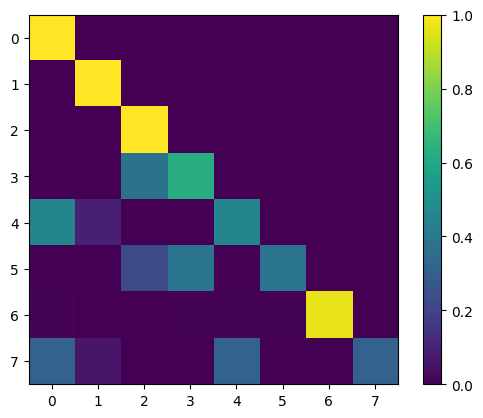

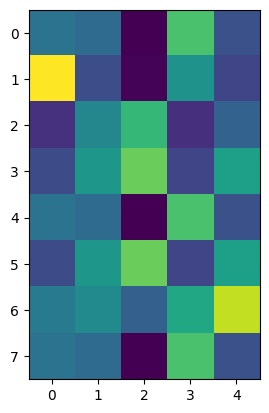

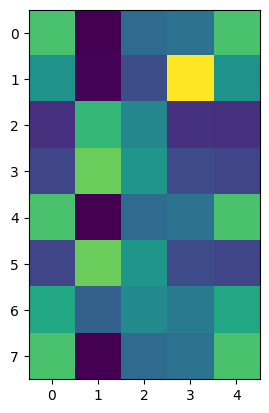

Predicted next token: 3


In [98]:
V = 5 # Vocabulary size
d = V # Embedding dimension for one-hot encoding
d_eff = 5 # Effective embedding dimension for Q, K, V
# embeddings = torch.eye(V, d) # One-hot encoding matrix
embeddings = torch.randn(V, d) # Random embedding matrix for demonstration
# Example of input sequence:
input = torch.tensor([1, 3, 0, 4, 1 , 4 , 2 , 1]) # Sequence of token indices
L = len(input) # Sequence length
# Positional encoding matrix (length L, dimension d) where all entries for position l are equal to l so that later positions have higher values

P = 0.*(L-torch.arange(L)).unsqueeze(1).repeat(1, d)/L
E = embeddings[input] # Embedded input sequence
X = E + P # One-hot encoded representation of the input sequence

Wq = torch.eye(d, d_eff) # Query projection matrix
Wk = torch.eye(d, d_eff) # Key projection matrix
Wv = torch.eye(d, d_eff) # Value projection matrix

Q = X @ Wq # Queries
K = X @ Wk # Keys

# Attention scores
S = Q @ K.transpose(-2, -1) 
# Causal mask to prevent attending to future tokens
mask = torch.tril(torch.ones(L,L)).bool()
S = S.masked_fill(~mask, float('-inf'))
A = torch.softmax(S, dim=-1) # Attention weights
# print(S)

plt.imshow(A.detach().numpy(), cmap='viridis')
plt.colorbar()
plt.show()

# Shifted value weigths so value i encodes token i+1
# Make it antydyagonal
Wv = torch.zeros(d, d_eff)
for i in range(d_eff):
    Wv[i, d_eff - i - 1] = 1.0
Wv = torch.roll(Wv, shifts=-1)
V = E @ Wv # Values

# print(E)
# print(Wv)
# print(V)
plt.imshow(E.detach().numpy(), cmap='viridis')
plt.show()
plt.imshow(V.detach().numpy(), cmap='viridis')
plt.show()


Y = A @ V # Output of the attention layer

# Wo also projection (identity here)
Wo = torch.eye(d_eff, d)
Y = Y @ Wo # Final output

y_last = Y[-1] # Output corresponding to the last input token
logits = y_last @ embeddings.transpose(0,1) # Logits for next token prediction
probs = torch.softmax(logits, dim=-1) # Probabilities for next token prediction
predicted_token = torch.argmax(probs).item() # Predicted next token
print(f"Predicted next token: {predicted_token}")

(7626,)


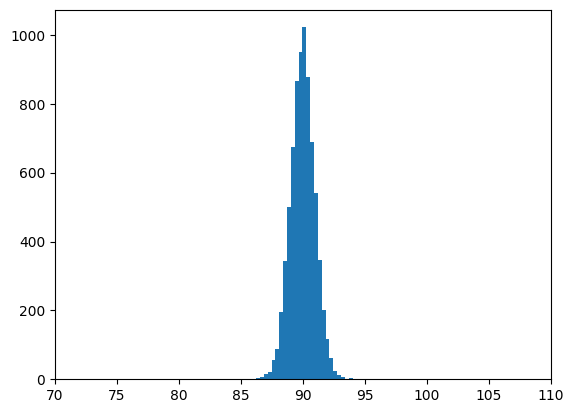

In [96]:
import numpy as np

n = 124
d = 500
d_eff = 60
X = np.random.randn(n,d)
W = np.random.randn(d,d_eff)
Y = X @ W /np.sqrt(d)
dot = Y @ Y.T/d # 
# get the elements just of the lower triangle, excluding the diagonal
elements = np.arccos(dot[np.tril_indices(n, k=-1)] ) * 180/np.pi
print(elements.shape)
plt.hist(elements, bins=30)
plt.xlim(70,110)
plt.show()